This program tries to locate variable stars, given the visual magnitudes of a set of stars over time.

In [2]:
#Import all libraries.
import pandas as pd
import math
from astropy.io import fits
import os
from astropy.wcs import WCS
import numpy as np
import keyring
from astroquery.astrometry_net import AstrometryNet
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import warnings
from IPython.display import clear_output
import os.path

warnings.filterwarnings('ignore')

The cell below is the only code that needs to be changed to analyze a set of stars. 


rawMira - The photometry output CSV from Mira that contains all the star and magnitude information. 

**NOTE:** This will only work with Mira-made apeture photometry CSVs. There are specific headers that are needed.

directory - The directory of all the files.

rawFit - A fits file from the image stack being analyzed. Can be any file from the stack.

croppedFitOutput - Where the 16 subsections used for solving WCS coordinates will go. Simply create a new folder in your directory and put the path name for this parameter.

parametersOutput - Name of the star parameters file.

AstrometryNet.key - Key of your account on Astrometry.net.

variabilityThreshold - Stars that have differential magnitudes varying more than this parameter (in standard deviations) will be flagged as possible variables.

uncertainThreshold - If simbad returns two or more stars within this radius of arcseconds, we don't know which star it is, so label it as "uncertain."

unclassifiedThreshold - If simbad can not find a star within this parameter of arcseconds or less, this star does not exist in the simbad catalogue and is classified as "unclassified."

comparisonThreshold - How similar the magnitude plots of two stars must be to consider them to be nonvariables. Set this parameter low if you want to decrease the number of comparison stars, or higher if you want to increase it. Experiment with this variable to produce the best results. In standard deviations. Typically set near 1.

numStars - Number of stars in the Mira photometry CSV.

numImages - Number of images in the stack being analyzed.

In [3]:
#PARAMETERS - User input.
#Program assumes Mira photometry CSV and that image is 4096x4096.

target = 'K01'

rawMira = './testdata4zach_v03.csv' 
directory = 'C:/Users/ronald.sumners/Desktop/KeplerTest3'
rawFit = 'C:/Users/ronald.sumners/Desktop/KeplerTest3/6661513_32683501_d_f1.fits'
croppedFitOutput = "C:/Users/ronald.sumners/Desktop/KeplerTest3/CroppedFit/K01_WCS_Crop_"
parametersOutput = 'KeplerTest3_Parameters.csv'

AstrometryNet.key = 'cibwfruamvhkzmdd'

variabilityThreshold = 1.5 #In standard deviations
comparisonThreshold = 1 #In standard deviations
uncertainThreshold = 4 #In arcseconds distance. The resolution of the BN is 3.8"/px
unclassifiedThreshold = 6 #In arcseconds distance.
numStars = 22
numImages = 64

#If you get an error saying "array not same length" decrease numComparison.
numComparison = 7

#Plotting y axis ranges from (mean-plotScale) to (mean+plotScale)
plotScale = 0.1

You can skip down to Cell 14 for results. Cells 3-13 are just calculations.

In [4]:
#Import the raw star photometry data from Mira CSV
starData = pd.read_csv(rawMira)
starData.columns = starData.columns.str.replace(' ', '')
starData = starData.set_index('#')

In [5]:
#Create star parameters dataframe. Get locations and names of stars. 
#Also get magnitude and error of each star. Store them in dataframes.
x = []
y = []
starName = starData['Name'][:numStars]

magnitude_dict = {}
errors_dict = {}
 
for i in range(numStars):
    #name1 = target + '-' + str(i)
    #starName.append(name1)
    clear_output(wait=True)
    print(f'PROGRESS: {(i/(numStars-1))*100:.1f}%')
    
    name1 = starName.iloc[i]
    
    x.append(starData['X'][starData['Name'] == name1].reset_index(drop=True)[0])
    y.append(starData['Y'][starData['Name'] == name1].reset_index(drop=True)[0])
    
    magnitude_dict[name1] = starData['Mag'][starData['Name'] == name1].reset_index(drop=True)
    errors_dict[name1] = starData['Error(T)'][starData['Name'] == name1].reset_index(drop=True)


starParams = pd.DataFrame(data={'x': x, 'y': y}, index=starName)

starMagnitudes = pd.DataFrame(magnitude_dict)
starErrors = pd.DataFrame(errors_dict)

PROGRESS: 100.0%


In [6]:
#Split the 4096x4096 photometry image into 16 different sections.

if not os.path.isfile(parametersOutput):
    data, header = fits.getdata(rawFit, header = True)

    for i in range(4):
        for j in range(4):
            hdu = fits.PrimaryHDU(data[1024*i:1024*(i+1), 1024*j:1024*(j+1)])
            hdu.writeto(croppedFitOutput + f"{4*i + j}.fits", overwrite = True)

    x = starParams['x']
    y = starParams['y']

    quad = []
    for i in range(numStars):
        quadrant_x = x[i]//1024
        quadrant_y = y[i]//1024
        quad.append(quadrant_x + 4*quadrant_y)

    starParams['Quadrant'] = quad
else:
    starParams = pd.read_csv(parametersOutput)
    starParams = starParams.set_index('Name')
    print('Already completed. Skip.')

Already completed. Skip.


In [7]:
#Run those split images through Astrometry to get WCS headers. 
#Use those headers to find the real sky coordinates of each star (RA/Dec).

if not os.path.isfile(parametersOutput):

    w = []
    for i in range(16):
        print(f'\nQuadrant {i}')

        try_again = True
        submission_id = None

        while try_again:
            try:
                if not submission_id:
                    # Solves the image from the file path
                    wcs_header = AstrometryNet.solve_from_image(croppedFitOutput + f'{i}.fits', force_image_upload=True,
                                                      submission_id=submission_id, detect_threshold=3, solve_timeout=1000)
                else:
                    #  Time is in seconds.
                    wcs_header = AstrometryNet.monitor_submission(
                        submission_id, solve_timeout=1000)
            except TimeoutError as e:
                #  Timeout error, never triggers. Basically useless code since it never triggers during timeout error
                submission_id = e.args[1]
                print('\nThere was a timeout error. ( Process took to long ).')
                print('Astometry.net could also be down at the moment.')
            else:
                #! got a result, so terminate
                try_again = False

        if wcs_header:
            w.append(wcs_header)


    Ra = []
    Dec = []
    for i in range(1, numStars + 1):
        quadrant = starParams['Quadrant'][i-1]
        wc = WCS(w[int(quadrant)])
        sky = wc.pixel_to_world_values(starParams.iloc[i-1, 0]-1024*(starParams.iloc[i-1, 0]//1024), starParams.iloc[i-1, 1]-1024*(starParams.iloc[i-1, 1]//1024))

        Ra.append(sky[0].item())
        Dec.append(sky[1].item())

    newra = [x + 0.00185728 for x in Ra]
    newdec = [y + 0.000917002 for y in Dec]

    starParams['RA'] = newra
    starParams['Dec'] = newdec
else:
    print('Already completed. Skip.')

Already completed. Skip.


In [8]:
#Look up what type of object each star is with Simbad (based on real coordinates found earlier).
#If object is within uncertainThreshold arcseconds of another, list type as uncertain. 
#If more than unclassifiedThreshold arcseconds, it is not catalogued.

if not os.path.isfile(parametersOutput):
    starTypeList = []

    custom_simbad = Simbad()
    custom_simbad.add_votable_fields('otype')
    custom_simbad.add_votable_fields('distance_result')
    types = []
    for i in range(numStars):
        clear_output(wait=True)
        print(f'PROGRESS: {(i/(numStars-1))*100:.1f}%')
        coord1 = starParams['RA'].iloc[i]
        coord2 = starParams['Dec'].iloc[i]

        c = SkyCoord(coord1, coord2, frame='icrs', unit='deg')

        transformed_c = c.to_string('hmsdms')

        r = 2 * u.arcminute

        result_table = custom_simbad.query_region(c, radius=r)

        try:
            starType = result_table['OTYPE'][0]

            if starType not in types:
                types.append(starType)

            starTypeList.append(starType)

            if len(result_table['DISTANCE_RESULT']) > 1:
                if (result_table['OTYPE'][0] == 'Planet' or  result_table['OTYPE'][1] == 'Planet'):
                    starTypeList[-1] = 'EXOPLANET'
                elif (result_table['DISTANCE_RESULT'][1]-result_table['DISTANCE_RESULT'][0]) < uncertainThreshold:
                    starTypeList[-1] = 'UNCERTAIN'
                elif (result_table['DISTANCE_RESULT'][0]) > unclassifiedThreshold:
                    starTypeList[-1] = 'UNCLASSIFIED'
            else:
                if result_table['DISTANCE_RESULT'][0] > unclassifiedThreshold:
                    starTypeList[-1] = 'UNCLASSIFIED'
        except TypeError:
            starTypeList.append('UNCLASSIFIED')
            continue


    starParams['Type'] = starTypeList
else:
    print('Already completed. Skip.')

Already completed. Skip.


In [9]:
#Confirm which stars are already classified variable stars. Remove them from the analysis.
#Make special note of which stars uncertain or unclassified.
#Uncertain stars MAY BE variables. Manual lookup needed.
#For the rest of the stars, use those who have variations less than x for differential photometry.

variables = starParams.index[
    (starParams['Type'] == 'RRLyrae') | (starParams['Type'] == 'EclBin') | 
    (starParams['Type'] == 'RotV*') | (starParams['Type'] == 'LongPeriodV*') | 
    (starParams['Type'] == 'LongPeriodV*_Candidate') | (starParams['Type'] == 'gammaDorV*')
    | (starParams['Type'] == 'delSctV*') | (starParams['Type'] == 'Variable*') | (starParams['Type'] == 'EclBin_Candidate')].tolist()
uncertain = starParams.index[(starParams['Type'] == 'UNCERTAIN') | (starParams['Type'] == 'UNCLASSIFIED')].tolist()
planets = starParams.index[starParams['Type'] == 'EXOPLANET'].tolist()
    
print(f'CONFIRMED VARAIBLE STARS - {len(variables)}: \n{variables}\n')
print(f'POSSIBLE EXOPLANET SYSTEMS - {len(planets)}: \n{planets}\n')
print(f'UNCERTAIN OR UNCLASSIFIED STARS - {len(uncertain)}: \n{uncertain}\n')

CONFIRMED VARAIBLE STARS - 3: 
['K01-1004', 'K01-1241', 'K01-1340']

POSSIBLE EXOPLANET SYSTEMS - 0: 
[]

UNCERTAIN OR UNCLASSIFIED STARS - 4: 
['K01-1106', 'K01-1162', 'K01-1169', 'K01-1209']



In [10]:
#Function to find the nearest neighbouring star. Copied from Github.

class KDTree(object):
    
    """
    A super short KD-Tree for points...
    so concise that you can copypasta into your homework 
    without arousing suspicion.

    This implementation only supports Euclidean distance. 

    The points can be any array-like type, e.g: 
        lists, tuples, numpy arrays.

    Usage:
    1. Make the KD-Tree:
        `kd_tree = KDTree(points, dim)`
    2. You can then use `get_knn` for k nearest neighbors or 
       `get_nearest` for the nearest neighbor

    points are be a list of points: [[0, 1, 2], [12.3, 4.5, 2.3], ...]
    """
    def __init__(self, points, dim, dist_sq_func=None):
        """Makes the KD-Tree for fast lookup.

        Parameters
        ----------
        points : list<point>
            A list of points.
        dim : int 
            The dimension of the points. 
        dist_sq_func : function(point, point), optional
            A function that returns the squared Euclidean distance
            between the two points. 
            If omitted, it uses the default implementation.
        """

        if dist_sq_func is None:
            dist_sq_func = lambda a, b: sum((x - b[i]) ** 2 
                for i, x in enumerate(a))
                
        def make(points, i=0):
            if len(points) > 1:
                points.sort(key=lambda x: x[i])
                i = (i + 1) % dim
                m = len(points) >> 1
                return [make(points[:m], i), make(points[m + 1:], i), 
                    points[m]]
            if len(points) == 1:
                return [None, None, points[0]]
        
        def add_point(node, point, i=0):
            if node is not None:
                dx = node[2][i] - point[i]
                for j, c in ((0, dx >= 0), (1, dx < 0)):
                    if c and node[j] is None:
                        node[j] = [None, None, point]
                    elif c:
                        add_point(node[j], point, (i + 1) % dim)

        import heapq
        def get_knn(node, point, k, return_dist_sq, heap, i=0, tiebreaker=1):
            if node is not None:
                dist_sq = dist_sq_func(point, node[2])
                dx = node[2][i] - point[i]
                if len(heap) < k:
                    heapq.heappush(heap, (-dist_sq, tiebreaker, node[2]))
                elif dist_sq < -heap[0][0]:
                    heapq.heappushpop(heap, (-dist_sq, tiebreaker, node[2]))
                i = (i + 1) % dim
                # Goes into the left branch, then the right branch if needed
                for b in (dx < 0, dx >= 0)[:1 + (dx * dx < -heap[0][0])]:
                    get_knn(node[b], point, k, return_dist_sq, 
                        heap, i, (tiebreaker << 1) | b)
            if tiebreaker == 1:
                return [(-h[0], h[2]) if return_dist_sq else h[2] 
                    for h in sorted(heap)][::-1]

        def walk(node):
            if node is not None:
                for j in 0, 1:
                    for x in walk(node[j]):
                        yield x
                yield node[2]

        self._add_point = add_point
        self._get_knn = get_knn 
        self._root = make(points)
        self._walk = walk

    def __iter__(self):
        return self._walk(self._root)
        
    def add_point(self, point):
        """Adds a point to the kd-tree.
        
        Parameters
        ----------
        point : array-like
            The point.
        """
        if self._root is None:
            self._root = [None, None, point]
        else:
            self._add_point(self._root, point)

    def get_knn(self, point, k, return_dist_sq=True):
        """Returns k nearest neighbors.

        Parameters
        ----------
        point : array-like
            The point.
        k: int 
            The number of nearest neighbors.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distances.

        Returns
        -------
        list<array-like>
            The nearest neighbors. 
            If `return_dist_sq` is true, the return will be:
                [(dist_sq, point), ...]
            else:
                [point, ...]
        """
        return self._get_knn(self._root, point, k, return_dist_sq, [])

    def get_nearest(self, point, return_dist_sq=True):
        """Returns the nearest neighbor.

        Parameters
        ----------
        point : array-like
            The point.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distance.

        Returns
        -------
        array-like
            The nearest neighbor. 
            If the tree is empty, returns `None`.
            If `return_dist_sq` is true, the return will be:
                (dist_sq, point)
            else:
                point
        """
        l = self._get_knn(self._root, point, 1, return_dist_sq, [])
        return l[0] if len(l) else None


In [11]:
#Calculates the distance metric to 10 neighbouring stars (a value used to determine which stars are nonvaring and able to be used as comparison stars.)

positions = list(zip(starParams['x'], starParams['y']))

x = np.linspace(0, 48, 48)

SDDict = {}

for i in range(numStars):
    name = starName.iloc[i]
    allComparisonDifferentials = pd.DataFrame({})
    distance = []
    flagCount = 0
    
    tree = KDTree(positions, 2)
    knn = tree.get_knn([starParams['x'].loc[name], starParams['y'].loc[name]], 11, False)
    
    
    starParamsSearch = starParams.reset_index()
    starParamsSearch = starParamsSearch.astype(str)
    
    clear_output(wait=True)
    print(f'PROGRESS: {(i/(numStars-1))*100:.1f}%')
    for coords in knn:
        
        x = str(coords[0])
        y = str(coords[1])
        
        comparisonName = starParamsSearch['Name'].loc[(starParamsSearch['x'] == x) & (starParamsSearch['y'] == y)].iloc[0]
        if comparisonName == name:
            continue        
        
        normalized1 = (starMagnitudes[name] - starMagnitudes[name].min())/(starMagnitudes[name].max() - starMagnitudes[name].min())
        normalized2 = (starMagnitudes[comparisonName] - starMagnitudes[comparisonName].min())/(starMagnitudes[comparisonName].max() - starMagnitudes[comparisonName].min())
        
        normalized1_smooth = savgol_filter(normalized1, 20, 2)
        normalized2_smooth = savgol_filter(normalized2, 20, 2)
        
        distance = 1/len(normalized1_smooth) * np.sum(np.square(normalized1_smooth - normalized2_smooth))
        SDDict[f'{name}-{comparisonName}'] = distance  

PROGRESS: 100.0%


In [12]:
#Calculates the standard deviation of distances to select which stars are nonvaring and able to be comparison stars.
comparisonStars = []
standardDeviation = np.std(list(SDDict.values()))

for i in range(numStars):
    name = starName.iloc[i]
    allComparisonDifferentials = pd.DataFrame({})
    distance = []
    flagCount = 0
    
    tree = KDTree(positions, 2)
    knn = tree.get_knn([starParams['x'].loc[name], starParams['y'].loc[name]], 11, False)
    
    
    starParamsSearch = starParams.reset_index()
    starParamsSearch = starParamsSearch.astype(str)
    
    clear_output(wait=True)
    print(f'PROGRESS: {(i/(numStars-1))*100:.1f}%')
    for coords in knn:
        
        x = str(coords[0])
        y = str(coords[1])
        
        comparisonName = starParamsSearch['Name'].loc[(starParamsSearch['x'] == x) & (starParamsSearch['y'] == y)].iloc[0]
        
        if comparisonName == name:
            continue  

        if SDDict[f'{name}-{comparisonName}'] > comparisonThreshold*standardDeviation:
            flagCount += 1
            
    if flagCount < 5 and name not in variables:
            comparisonStars.append(name)
print(f'There are {len(comparisonStars)} comparison stars.')

PROGRESS: 100.0%
There are 13 comparison stars.


In [13]:
#Calculates the difference in magnitude between star and the non variables found earlier.
#Output star parameters and magnitude differential to CSV.



differential_magnitude_dict = {}
comparisonStars_dict = {}
finalError_dict = {}

positions = list(zip(starParams['x'].loc[comparisonStars], starParams['y'].loc[comparisonStars]))

for j in range(numStars):
    totalDifferentials = pd.DataFrame({})
    totalErrors = pd.DataFrame({})
    tree = KDTree(positions, 2)
    
    name = starName.iloc[j]
    
    knn = tree.get_knn([starParams['x'].loc[name], starParams['y'].loc[name]], numComparison, False)

    differentialComparisonStars = []
    starParamsSearch = starParams.reset_index()
    starParamsSearch = starParamsSearch.astype(str)
    
    clear_output(wait=True)
    print(f'PROGRESS: {(j/(numStars-1))*100:.1f}%')
    
    for coords in knn:
        x = str(coords[0])
        y = str(coords[1])
        
        comparisonName = starParamsSearch['Name'].loc[(starParamsSearch['x'] == x) & (starParamsSearch['y'] == y)].iloc[0]
        differentialComparisonStars.append(comparisonName)
    
    
    comparisonStars_dict[name + ' Comparison'] = differentialComparisonStars
    for k in range(len(differentialComparisonStars)):
        name2 = differentialComparisonStars[k]
        
        differential = starMagnitudes[name] - starMagnitudes[name2]

        differentialError = np.sqrt(np.square(starErrors[name]) + np.square(starErrors[name2]))
        totalErrors = pd.concat([totalErrors, differentialError.rename(str(name2))], axis=1)
        
        totalDifferentials = pd.concat([totalDifferentials, differential.rename(str(k+1))], axis=1)
    
    differential_magnitude_dict[name + ' Differential'] = totalDifferentials.median(axis=1)

    finalError_dict[name + ' Error'] = np.sqrt(np.square(totalErrors).sum(axis=1))/numComparison


differentialMagnitudes = pd.DataFrame(differential_magnitude_dict)
differentials = pd.DataFrame(data = differentialMagnitudes)
differentials.to_csv(f'{target}_MagnitudeDifferentials.csv', index=False)

comparisonStarsDF = pd.DataFrame(comparisonStars_dict)
comparisonStarsDF.to_csv(f'{target}_ComparisonStars.csv', index=False)

finalErrorDF = pd.DataFrame(finalError_dict)
finalErrorDF.to_csv(f'{target}_DifferentialErrors.csv', index=False)

starParams.to_csv(parametersOutput, index=True)

PROGRESS: 100.0%


The following cells print results. The cell below prints photometry diagrams of all stars in a given range.

Change the start and rows parameters to increase or decrease number of plots and which plots to see in stack of stars.

For example, set rows to 5 and start to 25 if you want to see the 25th - 50th stars.

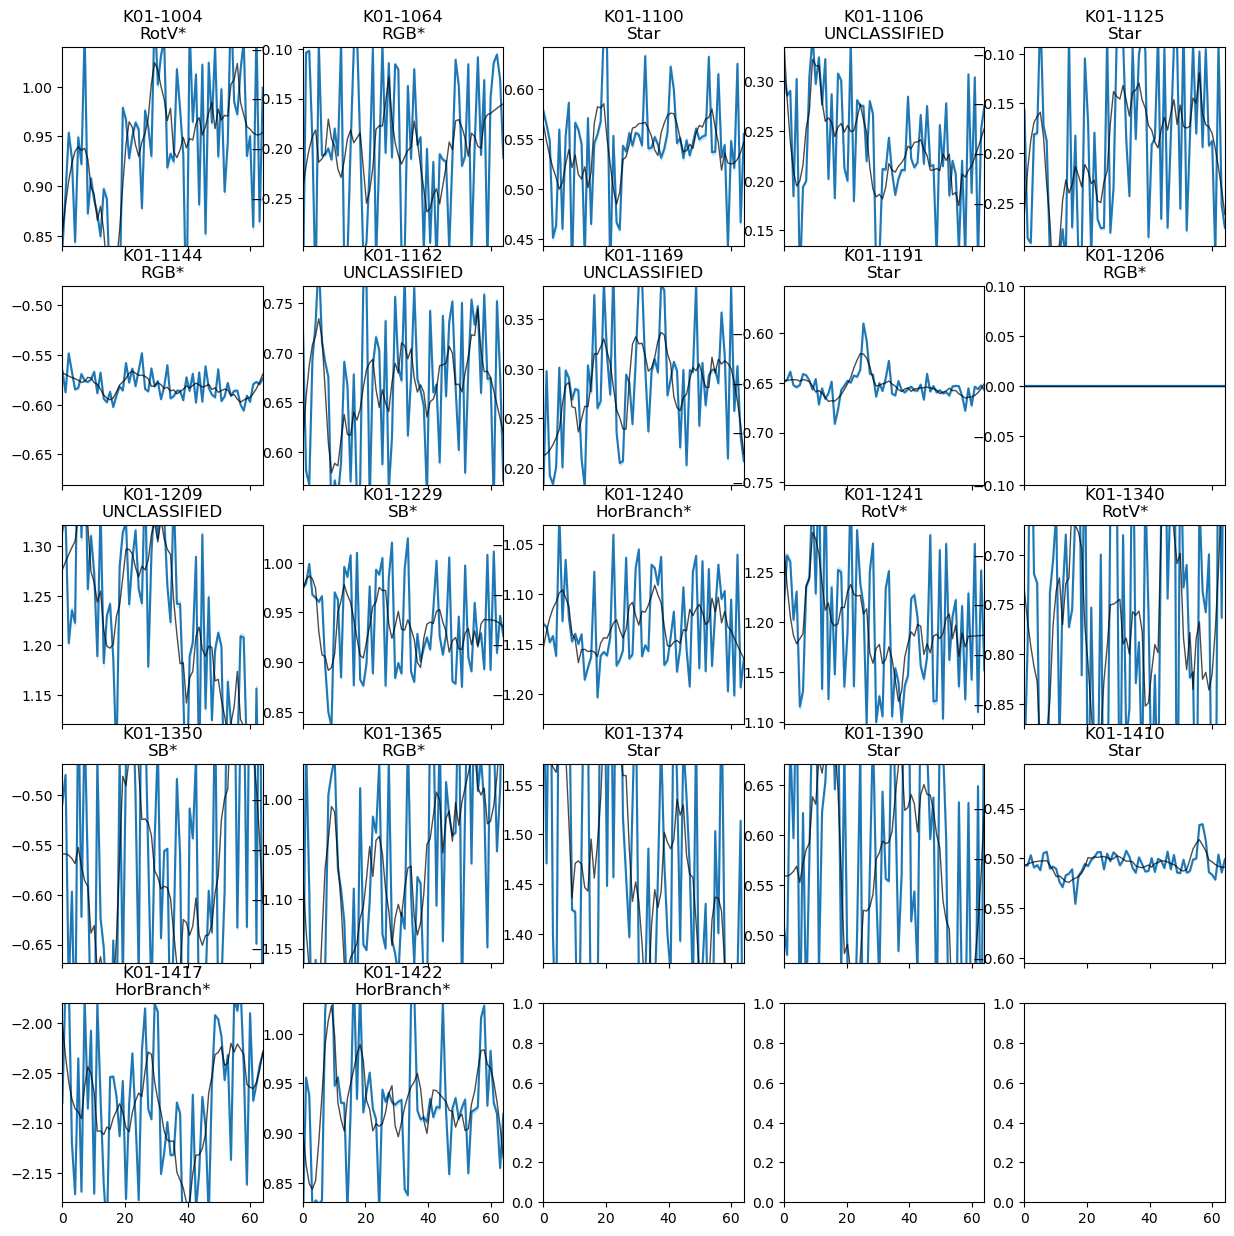

In [14]:
#Plot differential photometry of all stars.

rows = 5
start = 0

offset = 0
fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
count = 0

errorData = pd.read_csv(f'{target}_DifferentialErrors.csv')

for star in starName[start:start+5*rows]:
    j = count % 5
    i = count //5

    try:
        axs[i, j].plot(x, differentialMagnitudes[f'{star} Differential'])
        axs[i, j].fill_between(x, 
                   differentialMagnitudes[f'{star} Differential'] - errorData[f'{star} Error'],
                   differentialMagnitudes[f'{star} Differential'] + errorData[f'{star} Error'],
                   alpha=0.2, color='#26a8ff')
        smoothed = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 10, 2)
        axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
        axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
        axs[i, j].set_ylim(differentialMagnitudes[f'{star} Differential'].mean()-plotScale, differentialMagnitudes[f'{star} Differential'].mean()+plotScale)
        axs[i, j].set_xlim(0, numImages)

    except:
        continue
    count += 1

plt.show()

In [15]:
#Calculates the variability of each star.
variationDict = {}

for star in starName:
    try:
        mags_smooth = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 10, 2)
        variationDict[star] = mags_smooth.max() - mags_smooth.min()
    except:
        continue

In [16]:
#Classifies which of the stars have significant and important variation.
flagVariable = []

variabilityStandardDeviation = np.std(list(variationDict.values()))

for star in starName:   
    if variationDict[star] > variabilityThreshold*variabilityStandardDeviation:# and f'{star}' not in variables:
        flagVariable.append(f'{star}')

print(f'{len(flagVariable)} stars with variations above {variabilityThreshold*variabilityStandardDeviation} ({variabilityThreshold} standard deviations) magnitudes.')

10 stars with variations above 0.1759077127397737 (1.5 standard deviations) magnitudes.


The following cell prints the photometry plots of possible variable stars.

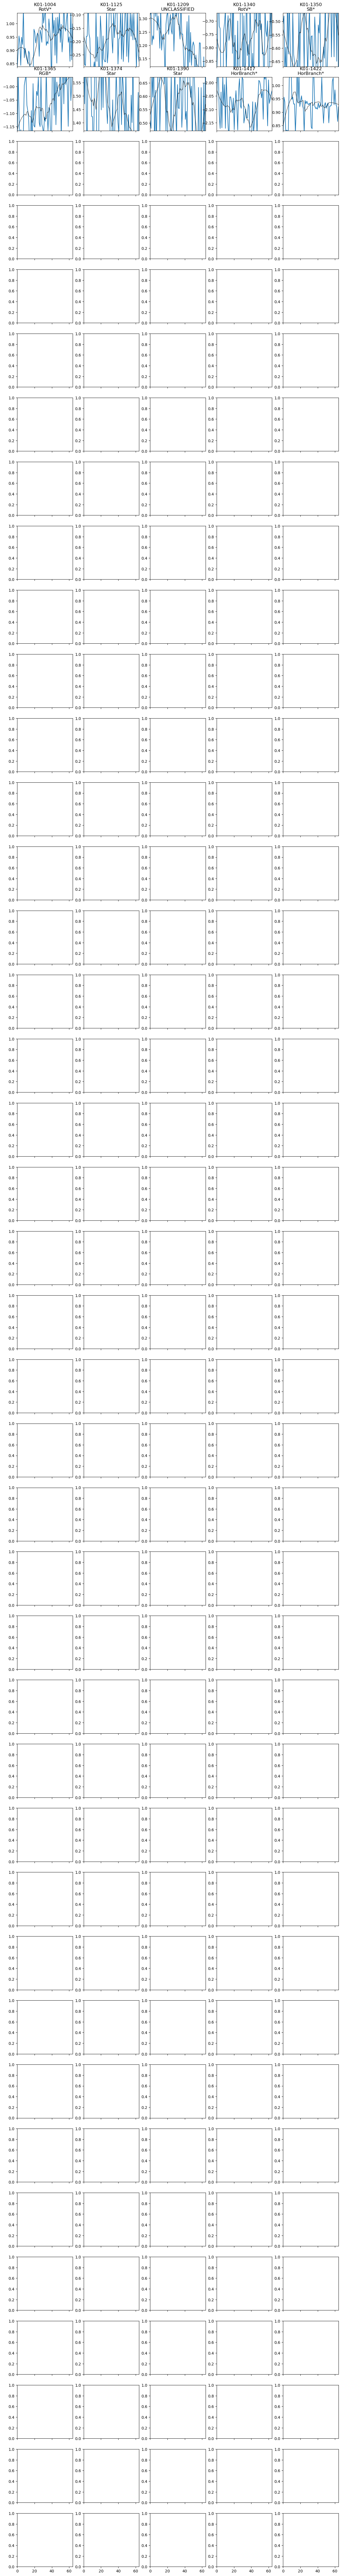

In [17]:
#Plot differential photometry of possible new variables.
rows = 40
start = 0

fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

count = 0

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
for star in flagVariable[start:start+5*rows]:
    j = count % 5
    i = count //5
    
    if i >= rows:
        break

    axs[i, j].plot(x, differentialMagnitudes[f'{star} Differential'])
    axs[i, j].fill_between(x, 
               differentialMagnitudes[f'{star} Differential'] - errorData[f'{star} Error'],
               differentialMagnitudes[f'{star} Differential'] + errorData[f'{star} Error'],
               alpha=0.2, color='#26a8ff')
    smoothed = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 20, 2)
    axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
    axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
    axs[i, j].set_ylim(differentialMagnitudes[f'{star} Differential'].mean()-plotScale, differentialMagnitudes[f'{star} Differential'].mean()+plotScale)
    axs[i, j].set_xlim(0, numImages)
    count += 1
    
plt.show()

This cell prints differential photometry plots of confirmed variable stars in the simbad catalogue.

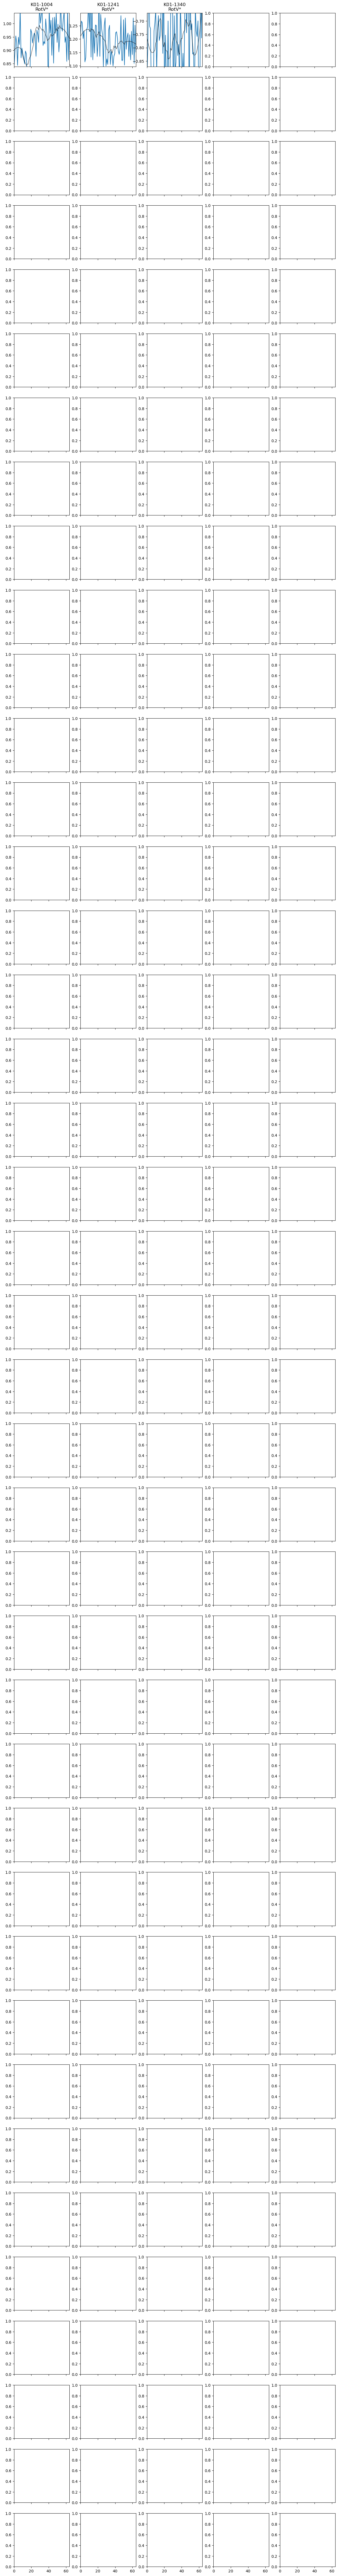

In [18]:
#Plot differential photometry of confirmed variables.
rows = 5
start = 0

fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

count = 0

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
for star in variables[start:start+5*rows]:
    j = count % 5
    i = count //5
    
    if i >= rows:
        break

    axs[i, j].plot(x, differentialMagnitudes[f'{star} Differential'])
    axs[i, j].fill_between(x, 
               differentialMagnitudes[f'{star} Differential'] - errorData[f'{star} Error'],
               differentialMagnitudes[f'{star} Differential'] + errorData[f'{star} Error'],
               alpha=0.2, color='#26a8ff')
    smoothed = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 20, 2)
    axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
    axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
    axs[i, j].set_ylim(differentialMagnitudes[f'{star} Differential'].mean()-plotScale, differentialMagnitudes[f'{star} Differential'].mean()+plotScale)
    axs[i, j].set_xlim(0, numImages)
    count += 1
    
plt.show()

This cell prints the differential photometry plots of confirmed stars with exoplanets.

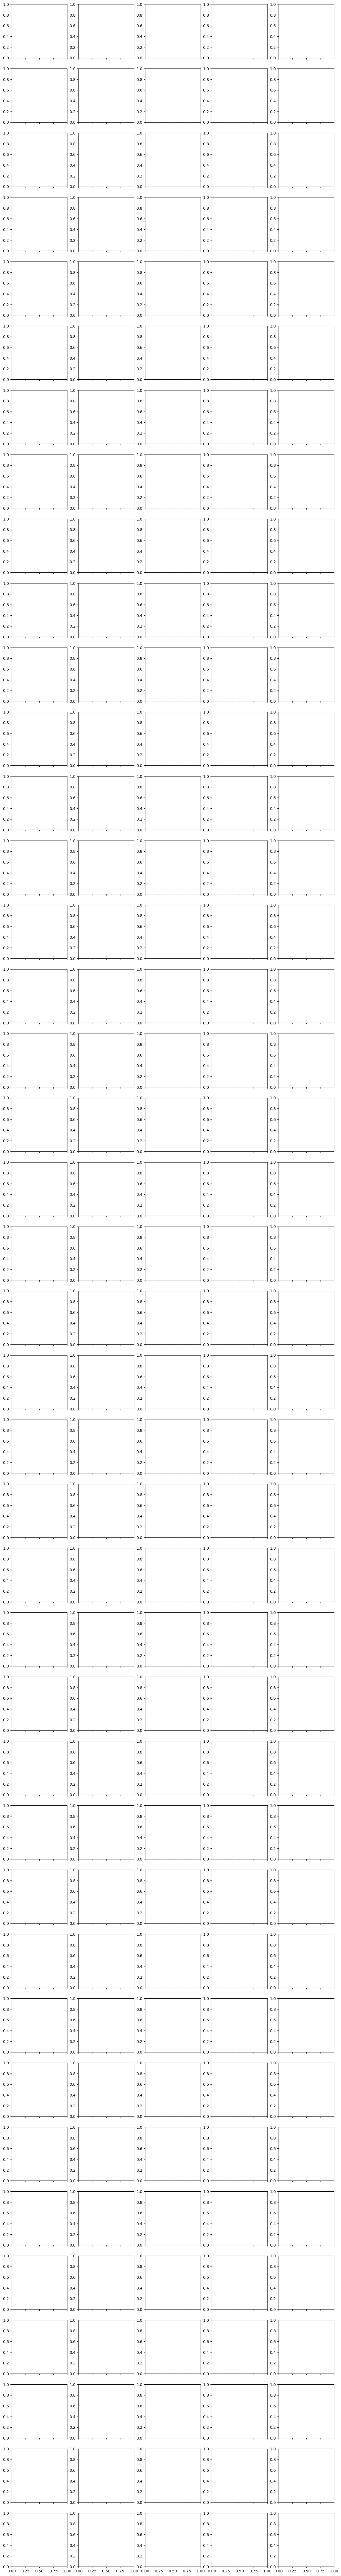

In [19]:
#Plot differential photometry of confirmed stars with exoplanets.
rows = 40
start = 0

fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

count = 0

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
for star in planets[start:start+5*rows]:
    j = count % 5
    i = count //5
    
    if i >= rows:
        break

    axs[i, j].plot(x, differentialMagnitudes[f'{star} Differential'])
    axs[i, j].fill_between(x, 
               differentialMagnitudes[f'{star} Differential'] - errorData[f'{star} Error'],
               differentialMagnitudes[f'{star} Differential'] + errorData[f'{star} Error'],
               alpha=0.2, color='#26a8ff')
    smoothed = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 20, 2)
    axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
    axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
    axs[i, j].set_ylim(differentialMagnitudes[f'{star} Differential'].mean()-plotScale, differentialMagnitudes[f'{star} Differential'].mean()+plotScale)
    axs[i, j].set_xlim(0, numImages)
    count += 1
    
plt.show()

The cell below prints the differential photometry plot of a single star. Select which star by changing the star parameter.

It also prints which comparison stars were used and where they are located. Blue is noncomparison stars, red is comparison stars and green is the star of interest.

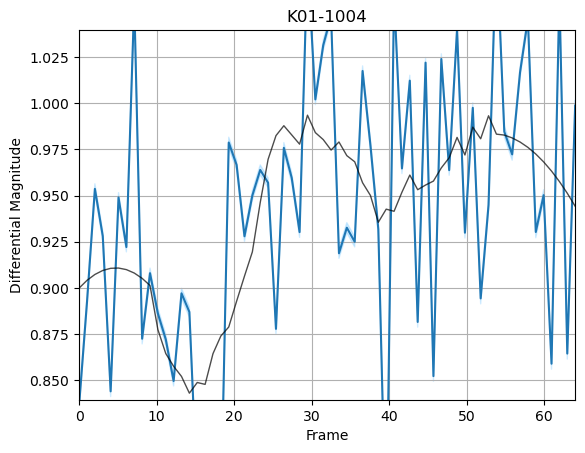

0    K01-1064
1    K01-1125
2    K01-1106
3    K01-1169
4    K01-1100
5    K01-1162
6    K01-1144
Name: K01-1004 Comparison, dtype: object


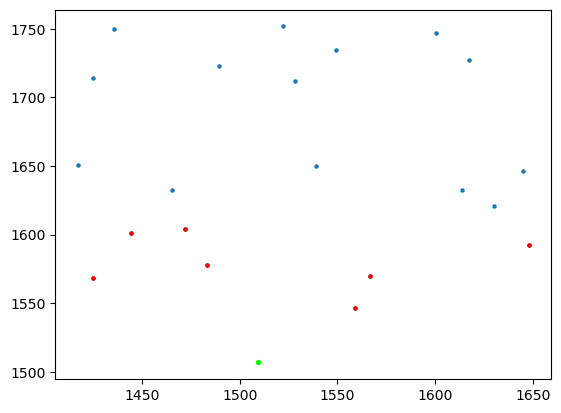

In [20]:
#Plot differential photometry of individual star for further investigation.

star = 1004

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))

figData = plt.gcf()
figData.set_size_inches(6.4, 4.8)

plt.plot(x, differentialMagnitudes[f'{target}-{star} Differential'].tolist())
plt.fill_between(x, 
               differentialMagnitudes[f'{target}-{star} Differential'].tolist() - errorData[f'{target}-{star} Error'],
              differentialMagnitudes[f'{target}-{star} Differential'].tolist() + errorData[f'{target}-{star} Error'],
               alpha=0.2, color='#26a8ff')

try:
    smoothed = savgol_filter(differentialMagnitudes[f'{target}-{star} Differential'].tolist(), 20, 2)
    plt.plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
except:
    pass

#plt.axvline(x=105, color='black')
#plt.text(106.5, differentialMagnitudes.iloc[:, star-1].mean() - 0.95, '10 DAY SKIP', rotation=90)
plt.grid()
plt.title(f'{target}-{star}')
plt.ylim(differentialMagnitudes[f'{target}-{star} Differential'].to_numpy().mean()-plotScale, differentialMagnitudes[f'{target}-{star} Differential'].to_numpy().mean()+plotScale)
plt.xlim(0, numImages)
plt.xlabel('Frame')
plt.ylabel('Differential Magnitude')
plt.show()

figData = plt.gcf()
figData.set_size_inches(6.4, 4.8)

selection = star

comparisonData = pd.read_csv(f'{target}_ComparisonStars.csv')

selected = comparisonData[f'{target}-{selection} Comparison']
print(selected)                
plt.scatter(starParams['x'], starParams['y'], s = 5)
for comparison in selected:
    plt.scatter(starParams['x'].loc[comparison], starParams['y'].loc[comparison], color='r', s = 5)
plt.scatter(starParams['x'].loc[f'{target}-{selection}'], starParams['y'].loc[f'{target}-{selection}'], color='#09ff00', s=8)

plt.show()

The following cell prints the base magnitude plot of the star of interest, specified by the star parameter. No differential photometry subtraction has taken place.

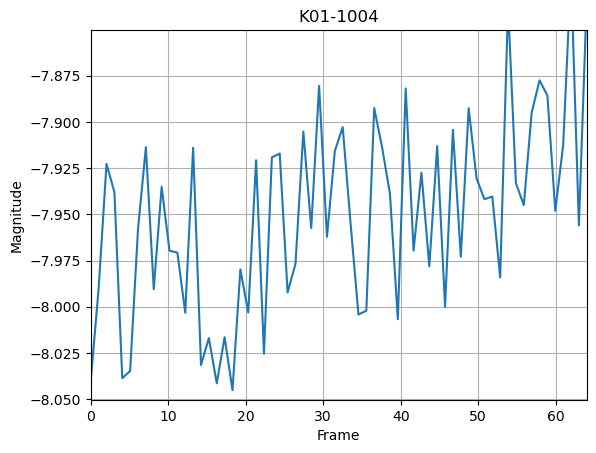

In [21]:
star = 1004
x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))

figData = plt.gcf()
figData.set_size_inches(6.4, 4.8)

plt.plot(x, starMagnitudes[f'{target}-{star}'].tolist())

plt.grid()
plt.title(f'{target}-{star}')
plt.ylim(starMagnitudes[f'{target}-{star}'].to_numpy().mean()-plotScale, starMagnitudes[f'{target}-{star}'].to_numpy().mean()+plotScale)
plt.xlim(0, numImages)
plt.xlabel('Frame')
plt.ylabel('Magnitude')
plt.show()

The following cell prints a picture of which stars are being analyzed in the image (red circles.)

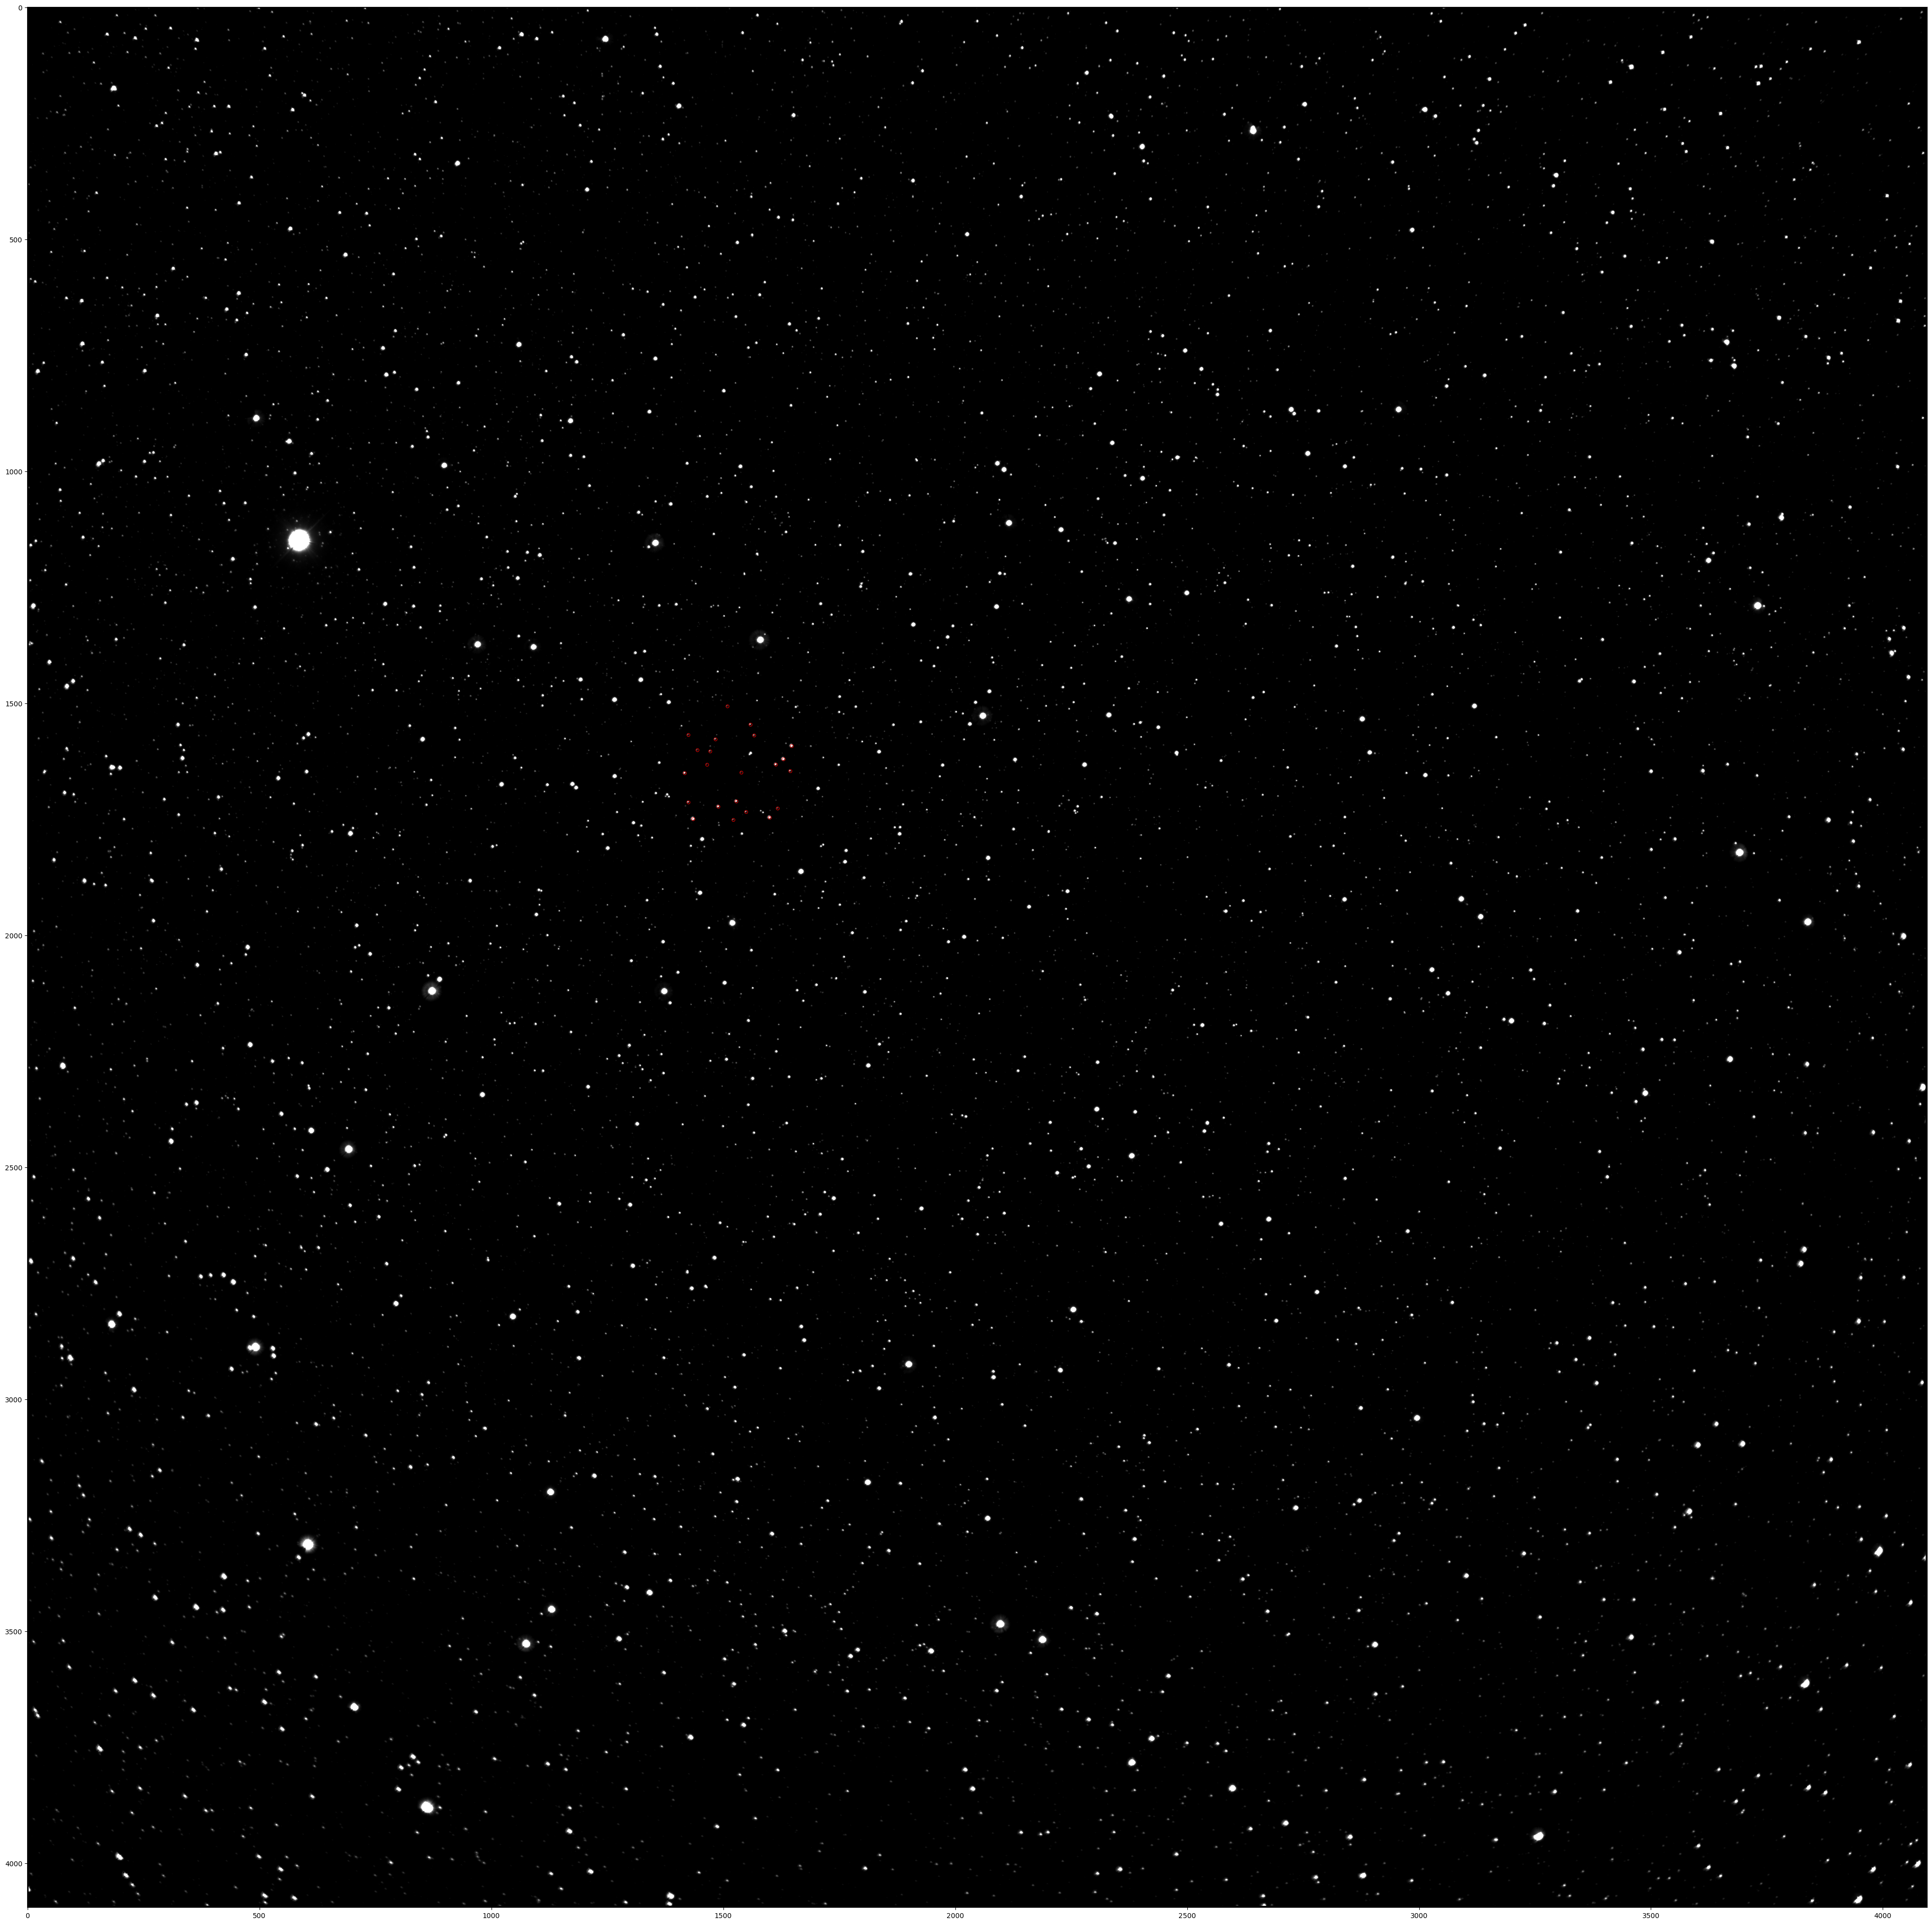

In [22]:
data, header = fits.getdata(rawFit, header = True)

figData = plt.gcf()
figData.set_size_inches(50, 50)


plt.imshow(data, cmap = 'gray', vmin = 5000, vmax = 30000)
plt.scatter(starParams['x'], starParams['y'], s = 20, facecolors='none', edgecolors='r', alpha = 0.7)
figData.savefig('markedStars.png', dpi=100)

This cell prints the nearest neighbours to the star of interest defined by "name."

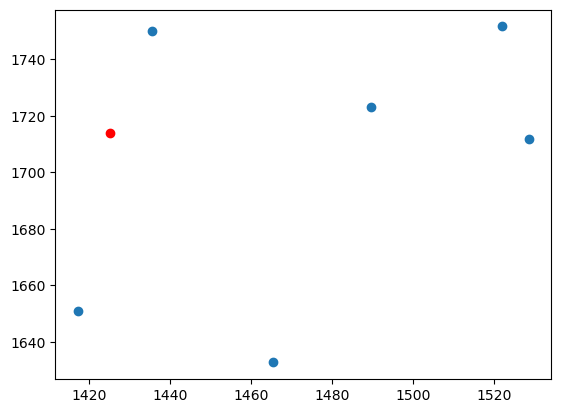

In [36]:
#Closest neighbours calculation.

name = 'K01-1350'
positions = list(zip(starParams['x'], starParams['y']))
xlist = []
ylist = []

tree = KDTree(positions, 2)
knn = tree.get_knn([starParams['x'].loc[name], starParams['y'].loc[name]], numComparison, False)


starParamsSearch = starParams.reset_index()
starParamsSearch = starParamsSearch.astype(str)


for coords in knn:
    x = str(coords[0])
    y = str(coords[1])

    comparisonName = starParamsSearch['Name'].loc[(starParamsSearch['x'] == x) & (starParamsSearch['y'] == y)].iloc[0]
    if comparisonName == name:
        plt.scatter(float(x), float(y), c='red')
    else:
        xlist.append(float(x))
        ylist.append(float(y))
        
plt.scatter(xlist, ylist)
plt.show()

The following cell prints the basic magnitude plots (no differential photometry) for all stars.

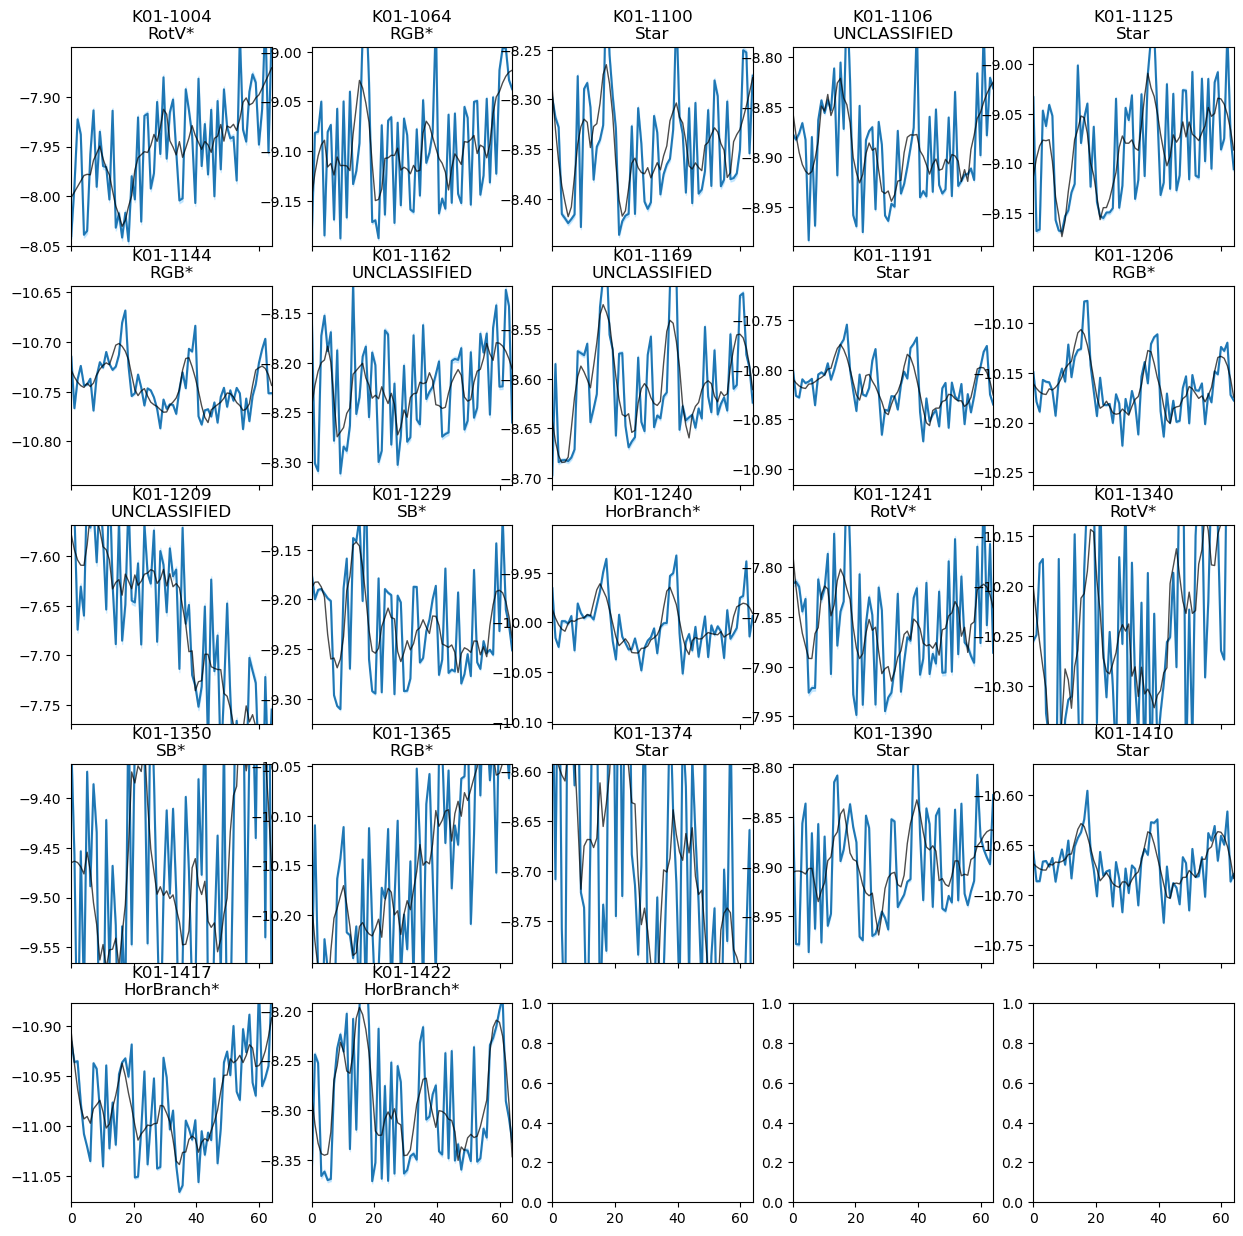

In [24]:
#Plot raw photometry of all stars.

rows = 5
start = 0

offset = 0
fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
count = 0

errorData = pd.read_csv(f'{target}_DifferentialErrors.csv')

for star in starName[start:start+5*rows]:
    j = count % 5
    i = count //5

    try:
        axs[i, j].plot(x, starMagnitudes[f'{star}'])
        axs[i, j].fill_between(x, 
                   starMagnitudes[f'{star}'] - errorData[f'{star} Error'],
                   starMagnitudes[f'{star}'] + errorData[f'{star} Error'],
                   alpha=0.2, color='#26a8ff')
        smoothed = savgol_filter(starMagnitudes[f'{star}'].to_numpy(), 10, 2)
        axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
        axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
        axs[i, j].set_ylim(starMagnitudes[f'{star}'].mean()-plotScale, starMagnitudes[f'{star}'].mean()+plotScale)
        axs[i, j].set_xlim(0, numImages)

    except:
        continue
    count += 1

plt.show()